# Shifted Grid Tests

## 3 Runs:
  - normal (Fortran)
  - shifted (everything else standard)
  - full improved (shifted, Richardson-Fermions, Coeffs-Bosons, γ-tail improve)

## Open Problems

  - First and last 2 frequencies for computation 3 are bad (reason?)
      - use old ν range sP.n_iν-sP.shift*(trunc(Int,sP.n_iω/2) )) ?
  - Σ_ladderLoc does not match Σ_DMFT for computation 2 and 3
      - γ .- γ2 could be a reason 
  - No coeffs for EoM

In [73]:
ENV["GKS_ENCODING"] = "utf-8"
using Plots
using LadderDGA
using Logging

io = stdout
metafmt(level::Logging.LogLevel, _module, group, id, file, line) = Logging.default_metafmt(level, nothing, group,     id, nothing, nothing)
logger = ConsoleLogger(io, Logging.Info, meta_formatter=metafmt, show_limited=true, right_justify=0)
global_logger(logger);

In [74]:
cfg_file = "/home/julian/Hamburg/lDGA_shift_tests/data/20_20_s0_b12_u1.0/config_j.toml";
cfg_file2 = "/home/julian/Hamburg/lDGA_shift_tests/data/20_20_s1_b12_u1.0/config_j.toml";
cfg_file3 = "/home/julian/Hamburg/lDGA_shift_tests/data/20_20_s1_b12_u1.0/config_j_s.toml";

mP, sP, env, kGrids, qGridLoc, freqList = readConfig(cfg_file)
kG = kGrids[1]
νGrid, sumHelper_f, impQ_sp, impQ_ch, GImp_fft, GLoc_fft, Σ_loc, FUpDo, gImp, gLoc = setup_LDGA(kG, freqList, mP, sP, env);

mP2, sP2, env2, kGrids2, qGridLoc2, freqList2 = readConfig(cfg_file2)
kG2 = kGrids2[1]
νGrid2, sumHelper_f2, impQ_sp2, impQ_ch2, GImp_fft2, GLoc_fft2, Σ_loc2, FUpDo2, gImp2, gLoc2 = setup_LDGA(kG2, freqList2, mP2, sP2, env2);


mP3, sP3, env3, kGrids3, qGridLoc3, freqList3 = readConfig(cfg_file3)
kG3 = kGrids3[1]
νGrid3, sumHelper_f3, impQ_sp3, impQ_ch3, GImp_fft3, GLoc_fft3, Σ_loc3, FUpDo3, gImp3, gLoc3 = setup_LDGA(kG3, freqList3, mP3, sP3, env3);

[ Info: Reading Inputs...
[ Warning: TODO: check beta consistency, config <-> g0man, chi_dir <-> gamma dir
[ Info: setting usable ranges of sp and ch channel from 13:29 and 13:29 to the same range of 13:29
┌ Info: Inputs Read. Starting Computation.
│ Local susceptibilities with ranges are:
│ χLoc_sp(13:29) = 0.1878, χLoc_ch(13:29) = 0.1175 
└ sum χupup check (fit, tail sub, tail sub + fit, expected): 0.1526666253073471 ?≈? 0.15266662530734712 ?=? 0.15266662530734712 ?≈? 0.25"
[ Info: Reading Inputs...
[ Warning: TODO: check beta consistency, config <-> g0man, chi_dir <-> gamma dir
[ Info: setting usable ranges of sp and ch channel from 13:29 and 13:29 to the same range of 13:29
┌ Info: Inputs Read. Starting Computation.
│ Local susceptibilities with ranges are:
│ χLoc_sp(13:29) = 0.1885, χLoc_ch(13:29) = 0.1182 
└ sum χupup check (fit, tail sub, tail sub + fit, expected): 0.15332433012444904 ?≈? 0.15332433012444904 ?=? 0.15332433012444904 ?≈? 0.25"
[ Info: Reading Inputs...
[ Warning: 

In [75]:
calc_Σ_dbg = LadderDGA.calc_Σ_dbg
# "local" correction quantities
bubbleLoc = calc_bubble(νGrid, GImp_fft, qGridLoc, mP, sP);
locQ_sp = calc_χ_trilex(impQ_sp.Γ, bubbleLoc, qGridLoc, νGrid, sumHelper_f, mP.U, mP, sP);
locQ_ch = calc_χ_trilex(impQ_ch.Γ, bubbleLoc, qGridLoc, νGrid, sumHelper_f, -mP.U, mP, sP);
Σ_ladderLoc,Σ_ladderLoc_ω,tmp_loc = calc_Σ_dbg(locQ_sp, locQ_ch, bubbleLoc, GImp_fft, FUpDo,
                     qGridLoc, sumHelper_f, mP, sP)
Σ_ladderLoc = Σ_ladderLoc .+ mP.n * mP.U/2.0;

bubbleLoc2 = calc_bubble(νGrid2, GImp_fft2, qGridLoc2, mP2, sP2);
locQ_sp2 = calc_χ_trilex(impQ_sp2.Γ, bubbleLoc2, qGridLoc, νGrid2, sumHelper_f2, mP2.U, mP2, sP2);
locQ_ch2 = calc_χ_trilex(impQ_ch2.Γ, bubbleLoc2, qGridLoc, νGrid2, sumHelper_f2, -mP2.U, mP2, sP2);
Σ_ladderLoc2,Σ_ladderLoc_ω2,tmp_loc2 = calc_Σ_dbg(locQ_sp2, locQ_ch2, bubbleLoc2, GImp_fft2, FUpDo2,
                     qGridLoc, sumHelper_f2, mP2, sP2)
Σ_ladderLoc2 = Σ_ladderLoc2 .+ mP2.n * mP2.U/2.0;

bubbleLoc3 = calc_bubble(νGrid3, GImp_fft3, qGridLoc3, mP3, sP3);
locQ_sp3 = calc_χ_trilex(impQ_sp3.Γ, bubbleLoc3, qGridLoc3, νGrid3, sumHelper_f3, mP3.U, mP3, sP3);
locQ_ch3 = calc_χ_trilex(impQ_ch3.Γ, bubbleLoc3, qGridLoc3, νGrid3, sumHelper_f3, -mP3.U, mP3, sP3);
Σ_ladderLoc3,Σ_ladderLoc_ω3,tmp_loc3 = calc_Σ_dbg(locQ_sp3, locQ_ch3, bubbleLoc3, GImp_fft3, FUpDo3,
                     qGridLoc3, sumHelper_f3, mP3, sP3)
Σ_ladderLoc3 = Σ_ladderLoc3 .+ mP3.n * mP3.U/2.0;

In [76]:
# non local quantities 
bubble = calc_bubble(νGrid, GLoc_fft, kG, mP, sP);
nlQ_sp = calc_χ_trilex(impQ_sp.Γ, bubble, kG, νGrid, sumHelper_f,  mP.U, mP, sP);
nlQ_ch = calc_χ_trilex(impQ_ch.Γ, bubble, kG, νGrid, sumHelper_f, -mP.U, mP, sP);

nlQ_sp_nλ = deepcopy(nlQ_sp)
nlQ_ch_nλ = deepcopy(nlQ_ch)
λ_sp, λ_spch  = λ_correction!(impQ_sp, impQ_ch, FUpDo, Σ_loc, Σ_ladderLoc, nlQ_sp, nlQ_ch, bubble, GLoc_fft, kG, mP, sP)

# non local quantities 
bubble2 = calc_bubble(νGrid2, GLoc_fft2, kG, mP2, sP2);
nlQ_sp2 = calc_χ_trilex(impQ_sp2.Γ, bubble2, kG, νGrid2, sumHelper_f2,  mP2.U, mP2, sP2);
nlQ_ch2 = calc_χ_trilex(impQ_ch2.Γ, bubble2, kG, νGrid2, sumHelper_f2, -mP2.U, mP2, sP2);

nlQ_sp2_nλ = deepcopy(nlQ_sp2)
nlQ_ch2_nλ = deepcopy(nlQ_ch2)
λ_sp2, λ_spch2  = λ_correction!(impQ_sp2, impQ_ch2, FUpDo2, Σ_loc2, Σ_ladderLoc2, nlQ_sp2, nlQ_ch2, bubble2, GLoc_fft2, kG, mP2, sP2)

# non local quantities 
bubble3 = calc_bubble(νGrid3, GLoc_fft3, kG3, mP3, sP3);
nlQ_sp3 = calc_χ_trilex(impQ_sp3.Γ, bubble3, kG3, νGrid3, sumHelper_f3,  mP3.U, mP3, sP3);
nlQ_ch3 = calc_χ_trilex(impQ_ch3.Γ, bubble3, kG3, νGrid3, sumHelper_f3, -mP3.U, mP3, sP3);

nlQ_sp3_nλ = deepcopy(nlQ_sp3)
nlQ_ch3_nλ = deepcopy(nlQ_ch3)
λ_sp3, λ_spch3  = λ_correction!(impQ_sp3, impQ_ch3, FUpDo3, Σ_loc3, Σ_ladderLoc3, nlQ_sp3, nlQ_ch3, bubble3, GLoc_fft3, kG3, mP3, sP3)

┌ Info: Computing λsp corrected χsp, using 
│   sP.χFillType = lambda_χ_fill::ChiFillType = 1
└    as fill value outside usable ω range. = " as fill value outside usable ω range."
[ Warning: currently using min(usable_sp, usable_ch) = min(14:28,14:28) = 14:28 for all calculations. relax this?
┌ Info: Found usable intervals for non-local susceptibility of length 
│ sp: 14:28, length: 15
│ ch: 14:28, length: 15
│ usable: 14:28, length: 15
└ χch sum = 0.1129179164891966, rhs = 0.1924153341254976
┌ Info: found 
│   χ_min = -0.24463037517440542
└   ". Looking for roots in intervall $(int)" = ". Looking for roots in intervall [-0.24463037517440542, 4.892607503488108]"
┌ Info: Found λsp 
└   λsp = 0.38061071388605944
[ Info: new lambda correction: λsp=0.0 and λch=0.0
┌ Info: Computing λsp corrected χsp, using 
│   sP.χFillType = lambda_χ_fill::ChiFillType = 1
└    as fill value outside usable ω range. = " as fill value outside usable ω range."
[ Warning: currently using min(usable_sp, usable_

(0.17920094249794716, [0.0, 0.0])

In [77]:
ωindices = (sP.dbg_full_eom_omega || sP.ωsum_type == :full) ? (1:size(bubbleLoc,1)) : intersect(locQ_sp.usable_ω, locQ_ch.usable_ω)
U = mP.U
χsp = locQ_sp.χ
χch = locQ_ch.χ
γsp = locQ_sp.γ
γch = locQ_ch.γ
shift = 0
ωZero = sP.n_iω
νZero = sP.n_iν
kGrid = qGridLoc
Gνω = GImp_fft
Σw = Array{Complex{Float64}}(undef, length(ωindices), 1, size(bubble,3))

for ωi in 1:length(ωindices)
    ωₙ = ωindices[ωi]
    fsp = 1.5 .* (1 .+ U*χsp[ωₙ, :])
    fch = 0.5 .* (1 .- U*χch[ωₙ, :])
    νZerop = 0 #νZero + shift*(trunc(Int64,(ωₙ - ωZero)/2))
    #println("w=$(ωₙ-sP2.n_iω-1), $(ωₙ) νi=$νZerop")
    for νi in 21:21
        #println("$(ωi), $(νi), $(νZerop+νi), $(tmp_loc[ωi,:,νZero+νi])")
        Kνωq = γsp[ωₙ, :, νZerop+νi] .* fsp .- γch[ωₙ, :, νZerop+νi] .* fch .- 1.5 .+ 0.5 .+ tmp_loc[ωi,:,νZerop+νi]
        Σw[ωi,:, νi] = LadderDGA.conv_fft1(kGrid, Kνωq, view(Gνω,νZerop + νi + ωₙ - 1,:))
    end
end

In [78]:
using Printf
ωindices2 = (sP2.dbg_full_eom_omega || sP2.ωsum_type == :full) ? (1:size(bubbleLoc2,1)) : intersect(locQ_sp2.usable_ω, locQ_ch2.usable_ω)
U = mP.U
χsp2 = locQ_sp2.χ
χch2 = locQ_ch2.χ
γsp2 = locQ_sp2.γ
γch2 = locQ_ch2.γ
shift2 = 1
ωZero2 = sP2.n_iω
νZero2 = sP2.n_iν
kGrid2 = qGridLoc
Gνω2 = GImp_fft2
Σw2 = Array{Complex{Float64}}(undef, length(ωindices), 1, size(bubble,3))
errors = Array{Complex{Float64},2}(undef, length(ωindices), 6)

println(" ω     Δγsp       Δχsp       Δγch       Δχch       Δtmp")
println("--------------------------------------------------------- ")
for ωi in 1:length(ωindices)
    ωₙ = ωindices[ωi]
    fsp = 1.5 .* (1 .+ U*χsp[ωₙ, :])
    fch = 0.5 .* (1 .- U*χch[ωₙ, :])
    νZerop = 0 #νZero + shift*(trunc(Int64,(ωₙ - ωZero)/2))
    
    fsp2 = 1.5 .* (1 .+ U*χsp2[ωₙ, :])
    fch2 = 0.5 .* (1 .- U*χch2[ωₙ, :])
    νZerop2 = 0 #νZero2 + shift2*(trunc(Int64,(ωₙ - ωZero2 - 1)/2))
    #println("wn=$(ωₙ) - $(ωZero2) => $(trunc(Int64,(ωₙ - ωZero2 - 1)/2))")
    for νi in 21:21
        #println("$(ωi), $(νi), $(νZerop2+νi), $(tmp_loc2[ωi,:,νZerop2+νi])")
        Kνωq = γsp[ωₙ, :, νZerop+νi]    .* fsp  .- γch[ωₙ, :, νZerop+νi]   .* fch .- 1.5 .+ 0.5 .+  tmp_loc[ωi,:, νZerop+νi]
        Σw[ωi,:, νi]  = LadderDGA.conv_fft1(kGrid, Kνωq , view(Gνω ,νZerop  + νi + ωₙ - 1,:))
        
        Kνωq2 = γsp2[ωₙ, :, νZerop2+νi] .* fsp2 .- γch2[ωₙ, :, νZerop2+νi] .* fch2 .-1.5 .+ 0.5 .+ tmp_loc2[ωi,:,νZerop2+νi]
        Σw2[ωi,:, νi] = LadderDGA.conv_fft1(kGrid, Kνωq2, view(Gνω2,νZerop2 + νi + ωₙ - 1,:))
        errors[ωi, : ] = [γsp[ωₙ, 1, νZerop+νi] .- γsp2[ωₙ, 1, νZerop2+νi]
                          χsp[ωₙ, 1] - χsp2[ωₙ, 1]
                          γch[ωₙ, 1, νZerop+νi]  .- γch2[ωₙ, 1, νZerop2+νi]
                          χch[ωₙ, 1] .- χch2[ωₙ, 1]
                          tmp_loc[ωi,1, νZerop+νi] .- tmp_loc2[ωi,1, νZerop+νi]
                          (γsp[ωₙ, :, νZerop+νi] .* fsp .- γch[ωₙ, :, νZerop+νi] .* fch) .- (γsp2[ωₙ, :, νZerop2+νi] .* fsp2 .- γch2[ωₙ, :, νZerop2+νi] .* fch2)]
        out = real.(errors[ωi, : ])
        @printf "%2d   %8.5f   %8.5f   %8.5f   %8.5f   %8.5f\n" ωₙ out[1] out[2] out[3] out[4] out[5]
    end
end

 ω     Δγsp       Δχsp       Δγch       Δχch       Δtmp
--------------------------------------------------------- 
 1   -0.00141   -0.02072   -0.00872   -0.02451    0.01885
 2   -0.00286   -0.01572   -0.00689   -0.01827    0.01489
 3   -0.00367   -0.01226   -0.00617   -0.01405    0.01182
 4   -0.00423   -0.00970   -0.00598   -0.01100    0.00939
 5   -0.00473   -0.00780   -0.00609   -0.00876    0.00751
 6   -0.00521   -0.00628   -0.00639   -0.00698    0.00596
 7   -0.00573   -0.00511   -0.00682   -0.00562    0.00474
 8   -0.00629   -0.00412   -0.00736   -0.00448    0.00368
 9   -0.00688   -0.00335   -0.00796   -0.00360    0.00286
10   -0.00754   -0.00267   -0.00867   -0.00283    0.00213
11   -0.00817   -0.00215   -0.00935   -0.00224    0.00157
12   -0.00887   -0.00167   -0.01014   -0.00171    0.00106
13   -0.00935   -0.00131   -0.01066   -0.00130    0.00072
14   -0.00989   -0.00097   -0.01129   -0.00093    0.00041
15   -0.00969   -0.00073   -0.01108   -0.00067    0.00028
16   -0.00956  

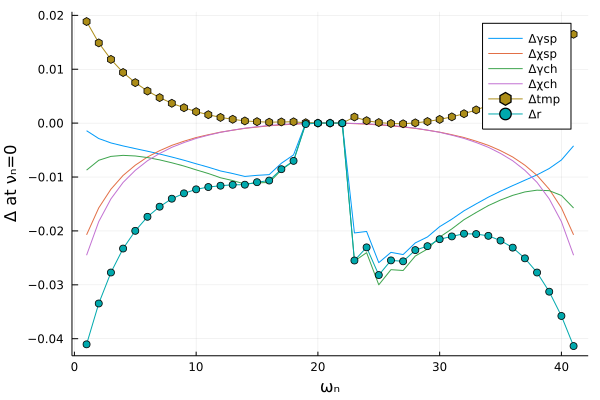

In [79]:
plot(real.(errors[:,1]), label="Δγsp", xlabel="ωₙ", ylabel="Δ at νₙ=0")
plot!(real.(errors[:,2]), label="Δχsp")
plot!(real.(errors[:,3]), label="Δγch")
plot!(real.(errors[:,4]), label="Δχch")
plot!(real.(errors[:,5]), label="Δtmp", markershape=:hexagon)
plot!(real.(errors[:,6]), label="Δr", markershape=:circle)

In [80]:
tmp_test1 = zeros(eltype(tmp),size(tmp_loc)...)
tmp_test2 = zeros(eltype(tmp),size(tmp_loc)...)
for ωi in 1:length(ωindices)
    ωₙ = ωindices[ωi]
    for qi in 1:size(bubbleLoc,2)
        for νi in 1:size(tmp,3)
            val = bubbleLoc[ωₙ,qi,:] .* FUpDo[ωₙ,νi,:]
            tmp_test1[ωi, qi, νi] = sum(val)
            val2 = bubbleLoc2[ωₙ,qi,:] .* FUpDo2[ωₙ,νi,:]
            tmp_test2[ωi, qi, νi] = sum(val2)
        end
    end
end

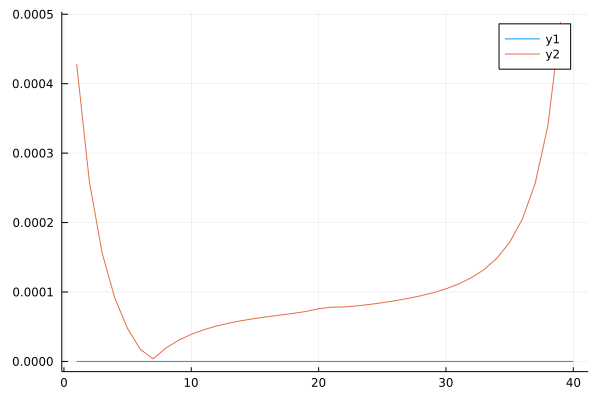

In [81]:
tmp_diff = tmp_loc[:,1,:] .- tmp_loc2[:,1,:]
plot(abs.(tmp_loc[21,1,:] .- tmp_loc2[21,1,:]))
plot!(abs.(tmp_loc[19,1,2:end] .- tmp_loc2[19,1,1:end-1]))
#plot!(abs.(tmp_loc[1,1,10:end] .- tmp_loc2[19,1,1:end-10]))

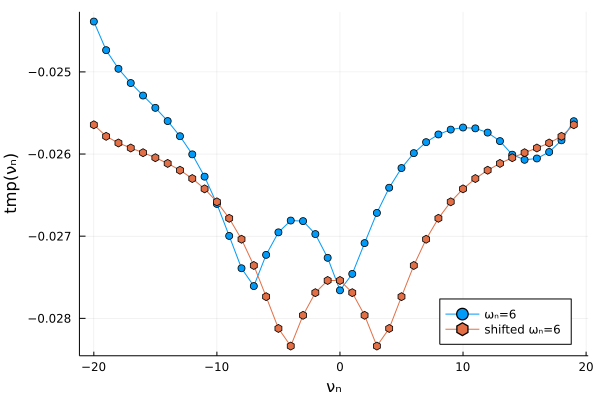

In [82]:
#plot(real(tmp_loc[22,1,:]), label="ω=0", legend=:right)
#plot!(real(tmp_loc2[22,1,:]), label="shift ω=0")
plot(-sP.n_iν:sP.n_iν-1, real(tmp_loc[27,1,:]), markershape=:circle, label="ωₙ=6", ylabel="tmp(νₙ)", xlabel="νₙ", legend=:bottomright)
plot!(-sP.n_iν:sP.n_iν-1, real(tmp_loc2[27,1,:]), markershape=:hexagon, label="shifted ωₙ=6")

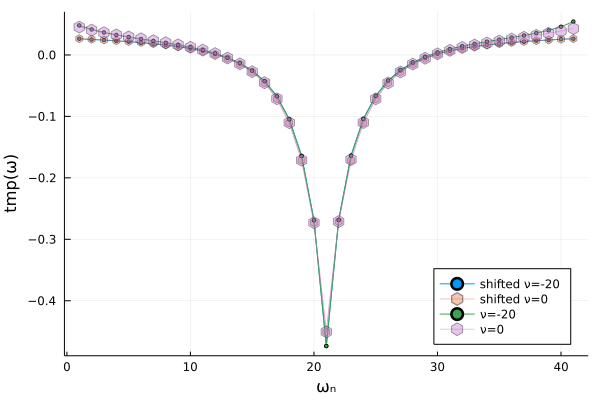

In [83]:
plot(real(tmp_loc2[:,1,1]), markershape=:circle, markersize=2, legend=:bottomright, label="shifted ν=-20", xlabel="ωₙ", ylabel="tmp(ω)")
plot!(real(tmp_loc2[:,1,21]),alpha=0.4, markershape=:hexagon, markersize=4, label="shifted ν=0")
plot!(real(tmp_loc[:,1,1]), markershape=:circle, markersize=2, label="ν=-20")
plot!(real(tmp_loc[:,1,21]),alpha=0.4, markershape=:hexagon, markersize=6, label="ν=0")

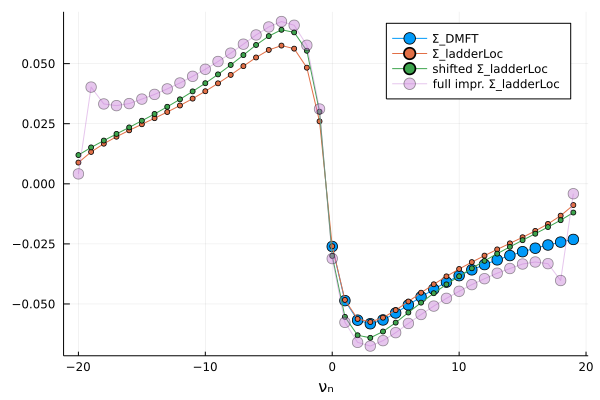

In [84]:
plot(0:19, imag(Σ_loc[1:20]), xlabel="νₙ", markershape=:circle, markersize=6, label="Σ_DMFT")
plot!(-20:19, imag(Σ_ladderLoc), markershape=:circle, markersize=3, label="Σ_ladderLoc")
plot!(-20:19, imag(Σ_ladderLoc2), markershape=:circle, markersize=3, label="shifted Σ_ladderLoc")
plot!(-20:19, imag(Σ_ladderLoc3), markershape=:circle, markersize=6, alpha=0.4, label="full impr. Σ_ladderLoc")

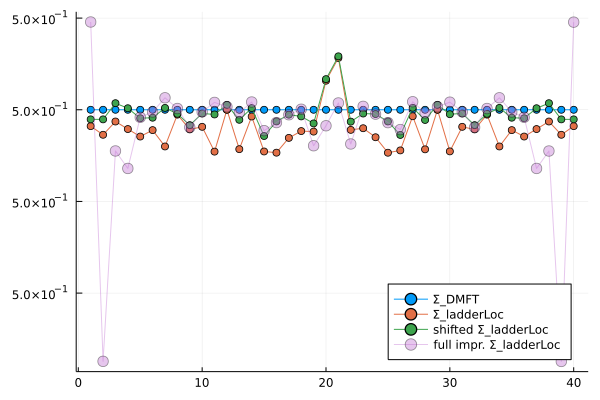

In [85]:
plot(real(Σ_loc[1:size(Σ_ladderLoc,1)]), markershape=:circle, label="Σ_DMFT", legend=:bottomright)
plot!(real(Σ_ladderLoc[:,:]), markershape=:circle, label="Σ_ladderLoc")
plot!(real(Σ_ladderLoc2[:,:]), markershape=:circle, label="shifted Σ_ladderLoc")
plot!(real(Σ_ladderLoc3[:,:]), markershape=:circle,markersize=6, alpha=0.4,  label="full impr. Σ_ladderLoc")

# Σ_ladderLoc_ω[20,1,:] 

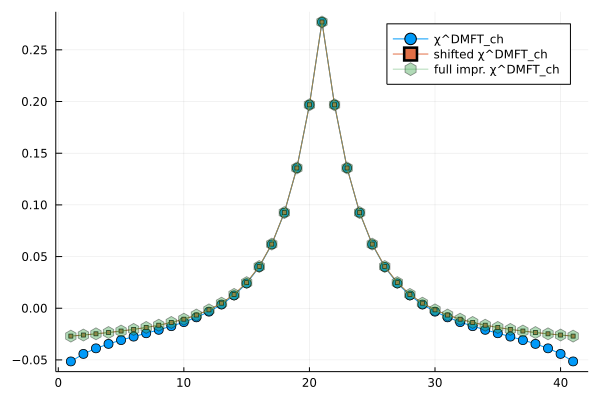

In [86]:
plot(real(locQ_ch.χ),markershape=:circle,  markersize=5, label="χ^DMFT_ch")
plot!(real(locQ_ch2.χ),markershape=:square,  markersize=2, label="shifted χ^DMFT_ch")
plot!(real(locQ_ch2.χ),markershape=:hexagon,markersize=6, alpha=0.4, label="full impr. χ^DMFT_ch")

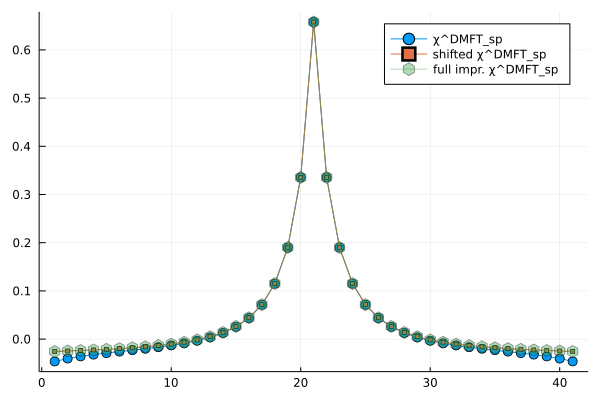

In [87]:
plot(real(locQ_sp.χ),markershape=:circle, markersize=5, alpha=1.0, label="χ^DMFT_sp")
plot!(real(locQ_sp2.χ),markershape=:square, markersize=2, alpha=1.0, label="shifted χ^DMFT_sp")
plot!(real(locQ_sp2.χ),markershape=:hexagon,markersize=6, alpha=0.4, label="full impr. χ^DMFT_sp")

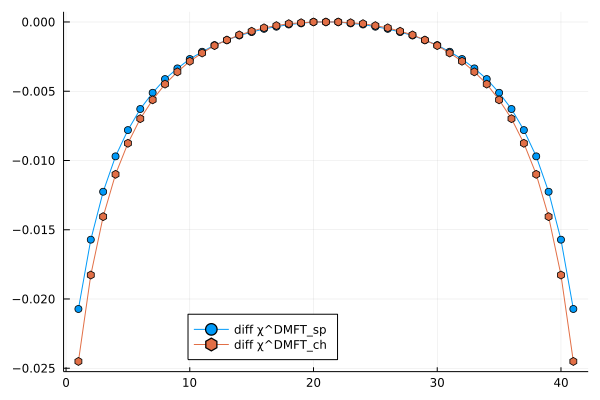

In [88]:
plot(real(locQ_sp.χ .- locQ_sp2.χ),markershape=:circle, label="diff χ^DMFT_sp", legend=:bottom)
plot!(real(locQ_ch.χ .- locQ_ch2.χ),markershape=:hexagon, label="diff χ^DMFT_ch")

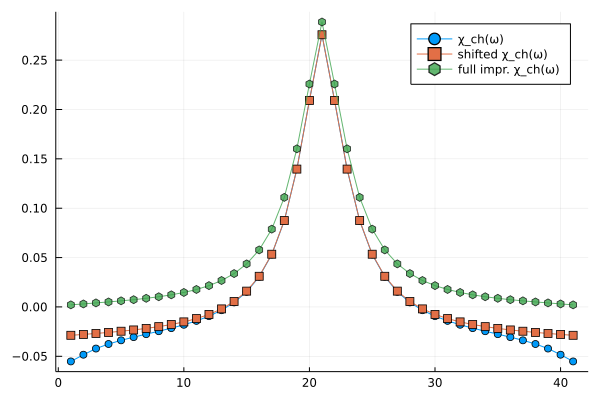

In [89]:
plot(real(LadderDGA.kintegrate(kG, nlQ_ch_nλ.χ, dim=2)[:,1]),markershape=:circle, label="χ_ch(ω)")
plot!(real(LadderDGA.kintegrate(kG, nlQ_ch2_nλ.χ, dim=2)[:,1]),markershape=:square, label="shifted χ_ch(ω)")
plot!(real(LadderDGA.kintegrate(kG, nlQ_ch3_nλ.χ, dim=2)[:,1]),markershape=:hexagon,markersize=4, alpha=0.8, label="full impr. χ_ch(ω)")

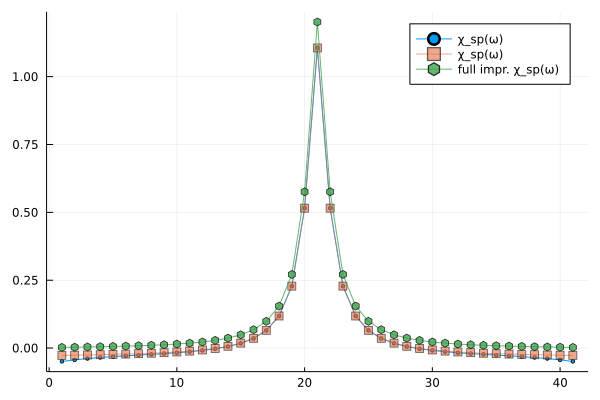

In [90]:
plot(real(LadderDGA.kintegrate(kG, nlQ_sp_nλ.χ, dim=2)[:,1]),markershape=:circle, markersize=2, label="χ_sp(ω)")
plot!(real(LadderDGA.kintegrate(kG, nlQ_sp2_nλ.χ, dim=2)[:,1]),markershape=:square, alpha=0.6, label="χ_sp(ω)")
plot!(real(LadderDGA.kintegrate(kG, nlQ_sp3_nλ.χ, dim=2)[:,1]),markershape=:hexagon,markersize=4, alpha=0.8, label="full impr. χ_sp(ω)")

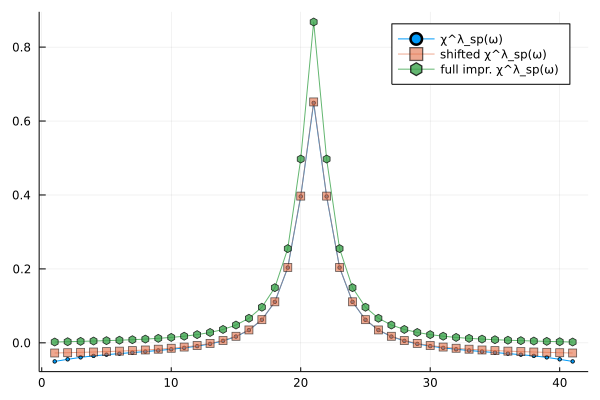

In [91]:
plot(real(LadderDGA.kintegrate(kG, nlQ_sp.χ, dim=2)[:,1]),markershape=:circle, markersize=2, label="χ^λ_sp(ω)")
plot!(real(LadderDGA.kintegrate(kG, nlQ_sp2.χ, dim=2)[:,1]),markershape=:square, alpha=0.6, label="shifted χ^λ_sp(ω)")
plot!(real(LadderDGA.kintegrate(kG, nlQ_sp3.χ, dim=2)[:,1]),markershape=:hexagon,markersize=4, alpha=0.8, label="full impr. χ^λ_sp(ω)")

# Investigation of Tail Fits in Σ(ω)

In [92]:
Σ_ladder,Σ_ladder_ω,tmp  = calc_Σ_dbg(nlQ_sp_nλ, nlQ_ch_nλ, bubble, GLoc_fft, FUpDo, kG, sumHelper_f, mP, sP)
Σ_ladder_corrected = Σ_ladder .- Σ_ladderLoc .+ Σ_loc[1:size(Σ_ladder,1)]

Σ_ladder2,Σ_ladder_ω2,tmp2 = calc_Σ_dbg(nlQ_sp2_nλ, nlQ_ch2_nλ, bubble2, GLoc_fft2, FUpDo2, kG2, sumHelper_f2, mP2, sP2)
Σ_ladder_corrected2 = Σ_ladder2 .- Σ_ladderLoc2 .+ Σ_loc[1:size(Σ_ladder2,1)];

Σ_ladder3,Σ_ladder_ω3,tmp3 = calc_Σ_dbg(nlQ_sp3_nλ, nlQ_ch3_nλ, bubble3, GLoc_fft3, FUpDo3, kG3, sumHelper_f3, mP3, sP3)
Σ_ladder_corrected3 = Σ_ladder3 .- Σ_ladderLoc3 .+ Σ_loc[1:size(Σ_ladder3,1)];

In [93]:
Σ_hartree = mP.n * mP.U/2 
E_pot_tail_c = (mP.U^2 * 0.5 * mP.n * (1-0.5*mP.n) .+ Σ_hartree .* (kG.ϵkGrid .+ Σ_hartree .- mP.μ))
E_pot_tail = E_pot_tail_c' ./ (LadderDGA.iν_array(mP.β, 0:size(Σ_ladder_corrected,1)-1) .^ 2)
E_pot_tail_inv = sum((mP.β/2)  .* [Σ_hartree .* ones(size(kG.ϵkGrid)), (-mP.β/2) .* E_pot_tail_c])
t = LadderDGA.G_from_Σ(Σ_ladder_corrected .+ Σ_hartree, kG.ϵkGrid, 0:size(Σ_ladder_corrected, 1)-1, mP)
G_corr = LadderDGA.flatten_2D(t);
E_pot_s = LadderDGA.calc_E_pot(kG, G_corr, Σ_ladder_corrected, E_pot_tail, E_pot_tail_inv) / mP.β
E_kin, E_pot = LadderDGA.calc_E(Σ_ladder_corrected,kG,mP,sP);
println("EPot single = $(E_pot_s), EPot = $(E_pot), EKin = $(E_kin) Total = $(E_pot[1] + E_kin[1])")

EPot single = 0.20865074359577618, EPot = [0.2086507435000026], EKin = [-0.5886226116970277] Total = -0.3799718681970251


In [94]:
Σ_hartree2 = mP2.n * mP2.U/2 
E_pot_tail_c2 = (mP2.U^2 * 0.5 * mP2.n * (1-0.5*mP2.n) .+ Σ_hartree2 .* (kG2.ϵkGrid .+ Σ_hartree2 .- mP2.μ))
E_pot_tail2 = E_pot_tail_c2' ./ (LadderDGA.iν_array(mP2.β, 0:size(Σ_ladder_corrected2,1)-1) .^ 2)
E_pot_tail_inv2 = sum((mP2.β/2)  .* [Σ_hartree2 .* ones(size(kG.ϵkGrid)), (-mP2.β/2) .* E_pot_tail_c2])
t2 = LadderDGA.G_from_Σ(Σ_ladder_corrected2 .+ Σ_hartree2, kG.ϵkGrid, 0:size(Σ_ladder_corrected2, 1)-1, mP2)
G_corr2 = LadderDGA.flatten_2D(t2);
E_pot_s2 = LadderDGA.calc_E_pot(kG, G_corr2, Σ_ladder_corrected2, E_pot_tail2[1:size(Σ_ladder_corrected2, 1),:], E_pot_tail_inv2) / mP.β
E_kin2, E_pot2 = LadderDGA.calc_E(Σ_ladder_corrected2,kG,mP2,sP2);
println("EPot single = $(E_pot_s2), EPot = $(E_pot2), EKin = $(E_kin2), Total = $(E_pot2[1] + E_kin2[1])")

EPot single = 0.20885378803701293, EPot = [0.20885378791902687], EKin = [-0.5888919087074301], Total = -0.38003812078840327


In [95]:
Σ_hartree3 = mP3.n * mP3.U/2 
E_pot_tail_c3 = (mP3.U^2 * 0.5 * mP3.n * (1-0.5*mP3.n) .+ Σ_hartree3 .* (kG3.ϵkGrid .+ Σ_hartree3 .- mP3.μ))
E_pot_tail3 = E_pot_tail_c3' ./ (LadderDGA.iν_array(mP3.β, 0:size(Σ_ladder_corrected3,1)-1) .^ 2)
E_pot_tail_inv3 = sum((mP3.β/2)  .* [Σ_hartree3 .* ones(size(kG3.ϵkGrid)), (-mP3.β/2) .* E_pot_tail_c3])
t3 = LadderDGA.G_from_Σ(Σ_ladder_corrected3 .+ Σ_hartree3, kG3.ϵkGrid, 0:size(Σ_ladder_corrected3, 1)-1, mP3)
G_corr3 = LadderDGA.flatten_2D(t3);
E_pot_s3 = LadderDGA.calc_E_pot(kG3, G_corr3, Σ_ladder_corrected3, E_pot_tail3[1:size(Σ_ladder_corrected3, 1),:], E_pot_tail_inv2) / mP.β
E_kin3, E_pot3 = LadderDGA.calc_E(Σ_ladder_corrected3,kG3,mP3,sP3);
println("EPot single = $(E_pot_s3), EPot = $(E_pot3), EKin = $(E_kin3), Total = $(E_pot3[1] + E_kin3[1])")

EPot single = -0.015112476837301983, EPot = [-0.015112476529170879], EKin = [-0.37306203265916116], Total = -0.388174509188332


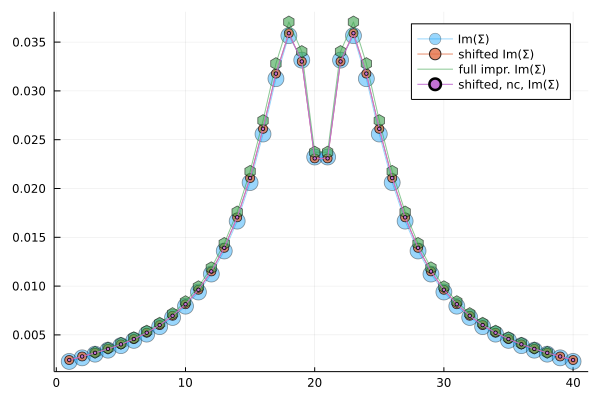

In [96]:
#plot(real(Σ_ladder[:,end]))
#plot!(real(Σ_ladder2[:,end]))
Σ_ladder_corrected3[[1,2,39,40],:] .= NaN
Σ_ladder3[[1,2,39,40],:] .= NaN
plot(real(Σ_ladder_corrected[:,end]), markershape=:circle, markersize=9, alpha=0.4, label="Im(Σ)")
plot!(real(Σ_ladder_corrected2[:,end]), markershape=:circle, markersize=5, alpha=0.8, label="shifted Im(Σ)")
plot!(real(Σ_ladder_corrected3[:,end]), markershape=:hexagon, markersize=6, alpha=0.6, label="full impr. Im(Σ)")
plot!(real(Σ_ladder2[:,end]), markershape=:circle, markersize=2, label="shifted, nc, Im(Σ)")

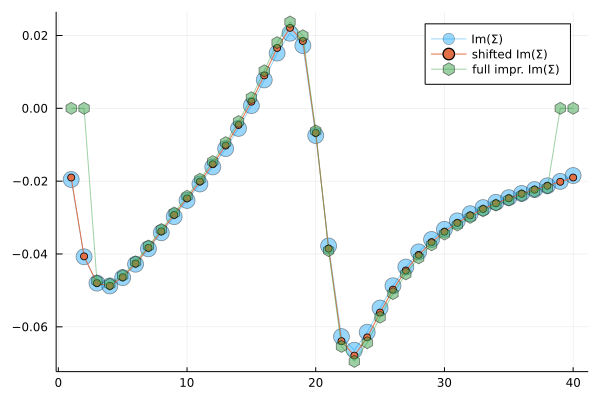

In [97]:
#plot(imag(Σ_ladder[:,end]))
plot(imag(Σ_ladder_corrected[:,end]), markershape=:circle, markersize=9, alpha=0.4, label="Im(Σ)")
plot!(imag(Σ_ladder_corrected2[:,end]), markershape=:circle, markersize=4, alpha=1.0, label="shifted Im(Σ)")
plot!(imag(Σ_ladder_corrected3[:,end]), markershape=:hexagon, markersize=6, alpha=0.5, label="full impr. Im(Σ)")

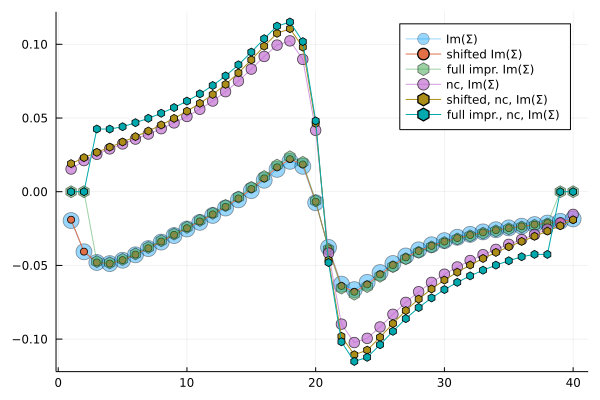

In [98]:
plot!(imag(Σ_ladder[:,end]), markershape=:circle,markersize=6, alpha=0.7, label="nc, Im(Σ)")
plot!(imag(Σ_ladder2[:,end]), markershape=:hexagon, label="shifted, nc, Im(Σ)")
plot!(imag(Σ_ladder3[:,end]), markershape=:hexagon, label="full impr., nc, Im(Σ)")

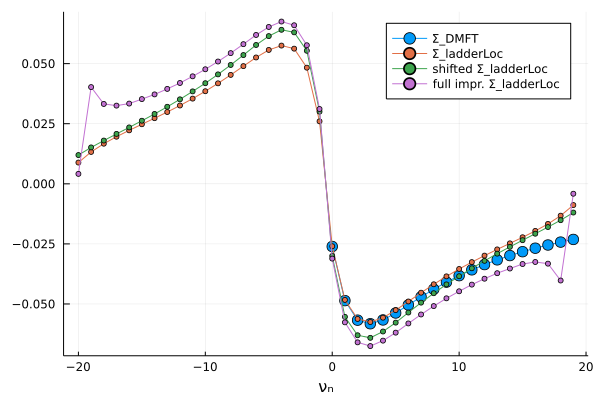

In [99]:
plot(0:19, imag(Σ_loc[1:20]), xlabel="νₙ", markershape=:circle, markersize=6, label="Σ_DMFT")
plot!(-20:19, imag(Σ_ladderLoc), markershape=:circle, markersize=3, label="Σ_ladderLoc")
plot!(-20:19, imag(Σ_ladderLoc2), markershape=:circle, markersize=3, label="shifted Σ_ladderLoc")
plot!(-20:19, imag(Σ_ladderLoc3), markershape=:circle, markersize=3, label="full impr. Σ_ladderLoc")